# Handwritten Digit Recognition with LeNet5 Model

In [1]:
# Install necessary libraries
!pip install torch torchvision numpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [1]:
# Importing Neccessary Libraries
import numpy as np  # Import the NumPy library for numerical operations
import struct # Import the struct library for working with binary data
import torch # Import PyTorch, a popular deep learning library
import torch.nn as nn # Import the neural network module from PyTorch
import torch.nn.functional as F # Import the functional module for various neural network operations
import torchvision.transforms as transforms # Import the transforms module from torchvision for image transformations
from torch.utils.data import Dataset, DataLoader # Import Dataset and DataLoader for handling data
import matplotlib.pyplot as plt # Import Matplotlib for plotting data

In [2]:
# Mount Google Drive to load data
from google.colab import drive # Import the drive module from Google Colab to interact with Google Drive
drive.mount('/content/drive')  # Mount Google Drive to the specified directory in the Colab environment

Mounted at /content/drive


# Preprocessing

In [3]:
# Define a dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.load_images(images_file) # Load images from the provided file path
        self.labels = self.load_labels(labels_file) # Load labels from the provided file path
        self.transform = transform # Store the transform function (if any) to apply to the images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
# Get the image and label at the given index
        image = self.images[idx]
        label = self.labels[idx]

 # Apply the transform to the image, if a transform is provided
        if self.transform:
            image = self.transform(image)
            return image, label # Return the image and label as a tuple

    def load_images(self, images_file):
        # Open the image file in binary mode
        with open(images_file, 'rb') as f:
            
             # Read the first 16 bytes which contain the magic number, number of images, and the dimensions (rows and columns) of each image
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            
            # Read the remaining bytes which contain the image data and reshape them into a 3D numpy array
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
        return images # Return the array of images

    def load_labels(self, labels_file):  # This method will contain the logic to load labels from the labels_file
        with open(labels_file, 'rb') as f:
            
            # Read the first 8 bytes which contain the magic number and the number of labels
            magic, num_labels = struct.unpack('>II', f.read(8))
            
            # Read the remaining bytes which contain the label data
            labels = np.fromfile(f, dtype=np.uint8)
            
        # Return the image and label as a tuple
        return labels

In [4]:
# Define paths to raw dataset files
# File paths for the MNIST dataset files
train_images_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition_model/train-images.idx3-ubyte'
train_labels_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition_model/train-labels.idx1-ubyte'
test_images_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition_model/t10k-images.idx3-ubyte'
test_labels_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition_model/t10k-labels.idx1-ubyte'

In [5]:
# Define transformations
# Define a transformation pipeline using Compose
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize tensor with mean and standard deviation
])

In [6]:
# Creating datasets for training and testing with transform applied
train_dataset = MNISTDataset(train_images_file, train_labels_file, transform=transform)
test_dataset = MNISTDataset(test_images_file, test_labels_file, transform=transform)

In [7]:
# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Sample Images Display

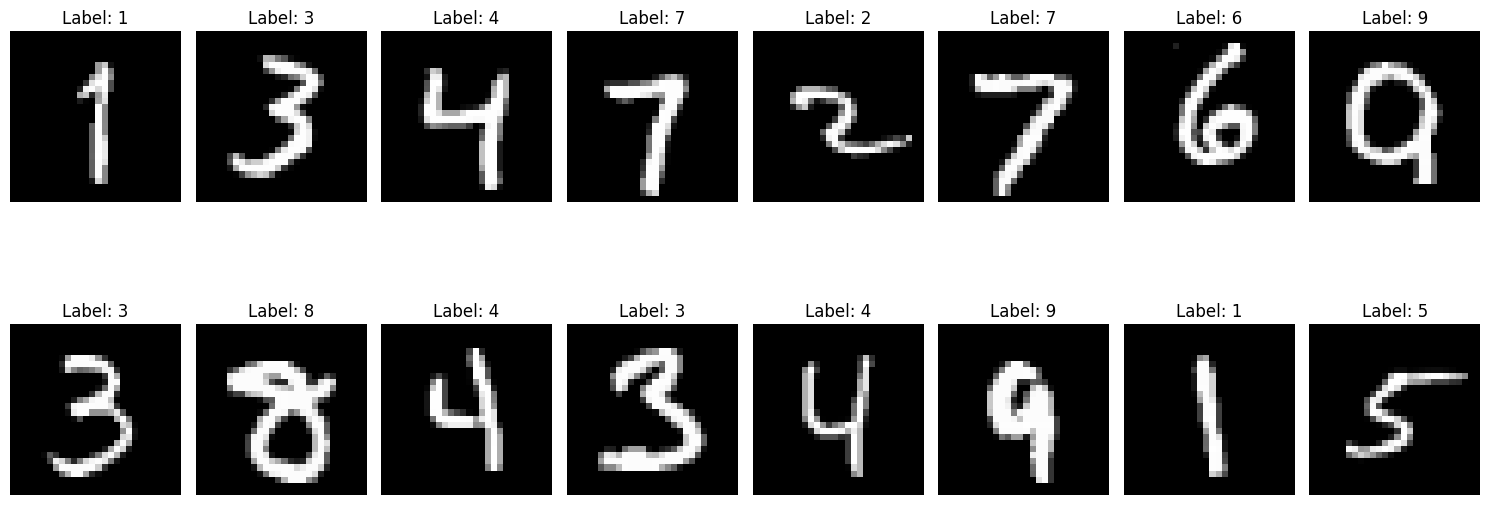

In [9]:
# Function to display images
def show_images(images, labels, ncols=8):
    # Calculate the number of rows needed to display all images
    nrows = np.ceil(len(images) / ncols).astype(int)
    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7))

    # Iterate through each subplot
    for i, ax in enumerate(axes.flat):
        # Check if the index is within the range of available images
        if i < len(images):
             # Display the image on the current subplot with grayscale colormap
            ax.imshow(images[i], cmap='gray')
            # Set the title of the subplot to display the corresponding label
            ax.set_title(f'Label: {labels[i]}')
         #Turn off axis ticks and labels for cleaner visualization
        ax.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Display sample images from train dataset
# Create a DataLoader instance for the train_dataset with a batch size of 16 and shuffling enabled
sample_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# Get a batch of images and labels from the DataLoader
sample_images, sample_labels = next(iter(sample_loader))
# Convert the batch of images from PyTorch tensors to NumPy arrays
sample_images = sample_images.numpy()

# Reshape images for plotting
sample_images = sample_images.reshape((-1, 28, 28))

# Show sample images
show_images(sample_images, sample_labels)

# Models Building

In [10]:
# MLP model
class MLP(nn.Module):
    def __init__(self):
        # Call the parent class (nn.Module) constructor
        super(MLP, self).__init__()
        # Define the first fully connected layer (input size: 28*28, output size: 128)
        self.fc1 = nn.Linear(28 * 28, 128)
        # Define the second fully connected layer (input size: 128, output size: 64)
        self.fc2 = nn.Linear(128, 64)
        # Define the third fully connected layer (input size: 64, output size: 10)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten the input tensor (batch_size, 28*28)
        x = x.view(-1, 28 * 28)
        # Apply ReLU activation function to the output of the first fully connected layer
        x = F.relu(self.fc1(x))
        # Apply ReLU activation function to the output of the second fully connected layer
        x = F.relu(self.fc2(x))
        # Pass the output through the third fully connected layer (no activation function here)
        x = self.fc3(x)
        # Return the output
        return x

In [11]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        # Call the parent class (nn.Module) constructor
        super(SimpleCNN, self).__init__()
        # Define the first convolutional layer (input channels: 1, output channels: 16, kernel size: 5x5)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # Define the second convolutional layer (input channels: 16, output channels: 32, kernel size: 5x5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        # Define the first fully connected layer (input size: 32 * 4 * 4, output size: 128)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        # Define the second fully connected layer (input size: 128, output size: 10)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(x))
        # Apply max pooling with a kernel size of 2x2
        x = F.max_pool2d(x, 2)
        # Apply the second convolutional layer followed by ReLU activation
        x = F.relu(self.conv2(x))
        # Apply max pooling with a kernel size of 2x2
        x = F.max_pool2d(x, 2)
        # Flatten the tensor into a shape compatible with the fully connected layer
        x = x.view(-1, 32 * 4 * 4)
         # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the second fully connected layer to produce the final output
        x = self.fc2(x)
        # Return the output
        return x

In [12]:
# LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        # Call the parent class (nn.Module) constructor
        super(LeNet5, self).__init__()
        # Define the first convolutional layer (input channels: 1, output channels: 6, kernel size: 5x5)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Define the second convolutional layer (input channels: 6, output channels: 16, kernel size: 5x5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Define the first fully connected layer (input size: 16 * 4 * 4, output size: 120)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        # Define the second fully connected layer (input size: 120, output size: 84)
        self.fc2 = nn.Linear(120, 84)
        # Define the third fully connected layer (input size: 84, output size: 10)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and average pooling
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 2)
        # Apply the second convolutional layer followed by ReLU activation and average pooling
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        # Flatten the tensor into a shape compatible with the fully connected layer
        x = x.view(-1, 16 * 4 * 4)
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        # Apply the third fully connected layer to produce the final output
        x = self.fc3(x)
        # Return the output
        return x


# Training and Testing Functions

In [13]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Initialize lists to store training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize running loss, correct predictions count, and total samples count
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over the batches of data from the training loader
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
             # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Update running loss
            running_loss += loss.item()
            # Get the predicted class (highest score)
            _, predicted = torch.max(outputs.data, 1)
            # Update correct predictions count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        train_loss = running_loss / len(train_loader)
        # Calculate training accuracy for the epoch
        train_acc = correct / total
        # Append the training loss to the train_losses list
        train_losses.append(train_loss)
        # Append the training accuracy to the train_accs list
        train_accs.append(train_acc)

         # Set the model to evaluation mode
        model.eval()
        # Initialize validation loss for the current epoch
        val_loss = 0.0
        # Initialize the count of correct predictions for the validation set
        correct = 0
         # Initialize the total count of samples for the validation set
        total = 0

        # Disable gradient calculation for validation to save memory and computations
        with torch.no_grad():
            # Loop over the batches of data from the validation loader
            for inputs, labels in val_loader:
                # Forward pass: compute predicted outputs by passing inputs to the model
                outputs = model(inputs)
                # Calculate the validation loss
                loss = criterion(outputs, labels)
                # Update running validation loss
                val_loss += loss.item()
                # Get the predicted class (highest score)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # Update correct predictions count for the validation set
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss for the epoch
        val_loss /= len(val_loader)
        # Calculate validation accuracy for the epoch
        val_acc = correct / total
        # Append the validation loss to the val_losses list
        val_losses.append(val_loss)
        # Append the validation accuracy to the val_accs list
        val_accs.append(val_acc)

        # Print the statistics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    #Return the lists of training and validation losses and accuracies
    return train_losses, val_losses, train_accs, val_accs

In [14]:
# Function to test the model
def test_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the count of correct predictions
    correct = 0
    # Initialize the total count of samples
    total = 0
    # Initialize lists to store all labels and predictions
    all_labels = []
    all_preds = []

    # Disable gradient calculation to save memory and computations during testing
    with torch.no_grad():
        # Loop over the batches of data from the test loader
        for inputs, labels in test_loader:
            # Perform a forward pass with the test inputs
            outputs = model(inputs)
            # Get the predicted class (highest score)
            _, predicted = torch.max(outputs.data, 1)
            # Update the total count of samples
            total += labels.size(0)
            # Update the count of correct predictions
            correct += (predicted == labels).sum().item()
            # Extend the list of all labels with the current batch labels
            all_labels.extend(labels)
            # Extend the list of all predictions with the current batch predictions
            all_preds.extend(predicted)

    # Calculate the test accuracy
    test_acc = correct / total
    # Print the test accuracy
    print(f'Test Accuracy: {test_acc:.4f}')

    # Return the test accuracy, all labels, and all predictions
    return test_acc, all_labels, all_preds


In [15]:
# Instantiate models
# Instantiate the MLP model
mlp_model = MLP()

# Instantiate the SimpleCNN model
cnn_model = SimpleCNN()

# Instantiate the LeNet5 model
lenet_model = LeNet5()


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_lenet = torch.optim.Adam(lenet_model.parameters(), lr=0.001)

# Models Training

In [17]:
# Train MLP model
mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = train_model(mlp_model, train_loader, val_loader, criterion, optimizer_mlp)


Epoch [1/10], Train Loss: 0.4598, Train Acc: 0.8660, Val Loss: 0.2841, Val Acc: 0.9141
Epoch [2/10], Train Loss: 0.2281, Train Acc: 0.9311, Val Loss: 0.1864, Val Acc: 0.9437
Epoch [3/10], Train Loss: 0.1598, Train Acc: 0.9517, Val Loss: 0.1604, Val Acc: 0.9516
Epoch [4/10], Train Loss: 0.1309, Train Acc: 0.9595, Val Loss: 0.1239, Val Acc: 0.9627
Epoch [5/10], Train Loss: 0.1076, Train Acc: 0.9667, Val Loss: 0.1237, Val Acc: 0.9623
Epoch [6/10], Train Loss: 0.0956, Train Acc: 0.9700, Val Loss: 0.1311, Val Acc: 0.9580
Epoch [7/10], Train Loss: 0.0847, Train Acc: 0.9735, Val Loss: 0.1155, Val Acc: 0.9654
Epoch [8/10], Train Loss: 0.0735, Train Acc: 0.9763, Val Loss: 0.1093, Val Acc: 0.9673
Epoch [9/10], Train Loss: 0.0662, Train Acc: 0.9781, Val Loss: 0.1086, Val Acc: 0.9679
Epoch [10/10], Train Loss: 0.0627, Train Acc: 0.9794, Val Loss: 0.1101, Val Acc: 0.9688


In [20]:
# Save the MLP model
model_path = "mlp_model.pth"
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mlp_model.pth


In [18]:
# Train Simple CNN model
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(cnn_model, train_loader, val_loader, criterion, optimizer_cnn)


Epoch [1/10], Train Loss: 0.2060, Train Acc: 0.9385, Val Loss: 0.0605, Val Acc: 0.9818
Epoch [2/10], Train Loss: 0.0530, Train Acc: 0.9831, Val Loss: 0.0475, Val Acc: 0.9847
Epoch [3/10], Train Loss: 0.0367, Train Acc: 0.9882, Val Loss: 0.0438, Val Acc: 0.9870
Epoch [4/10], Train Loss: 0.0281, Train Acc: 0.9912, Val Loss: 0.0354, Val Acc: 0.9882
Epoch [5/10], Train Loss: 0.0236, Train Acc: 0.9922, Val Loss: 0.0325, Val Acc: 0.9904
Epoch [6/10], Train Loss: 0.0185, Train Acc: 0.9938, Val Loss: 0.0401, Val Acc: 0.9884
Epoch [7/10], Train Loss: 0.0147, Train Acc: 0.9951, Val Loss: 0.0368, Val Acc: 0.9896
Epoch [8/10], Train Loss: 0.0128, Train Acc: 0.9957, Val Loss: 0.0365, Val Acc: 0.9904
Epoch [9/10], Train Loss: 0.0117, Train Acc: 0.9961, Val Loss: 0.0341, Val Acc: 0.9902
Epoch [10/10], Train Loss: 0.0103, Train Acc: 0.9965, Val Loss: 0.0358, Val Acc: 0.9898


In [21]:
# Save the Simple CNN model
model_path = "simple_cnn_model.pth"
torch.save(cnn_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to simple_cnn_model.pth


In [19]:
# Train LeNet-5 model
lenet_train_losses, lenet_val_losses, lenet_train_accs, lenet_val_accs = train_model(lenet_model, train_loader, val_loader, criterion, optimizer_lenet)

Epoch [1/10], Train Loss: 0.2937, Train Acc: 0.9074, Val Loss: 0.0914, Val Acc: 0.9719
Epoch [2/10], Train Loss: 0.0797, Train Acc: 0.9754, Val Loss: 0.0721, Val Acc: 0.9771
Epoch [3/10], Train Loss: 0.0584, Train Acc: 0.9816, Val Loss: 0.0511, Val Acc: 0.9837
Epoch [4/10], Train Loss: 0.0437, Train Acc: 0.9870, Val Loss: 0.0478, Val Acc: 0.9847
Epoch [5/10], Train Loss: 0.0366, Train Acc: 0.9885, Val Loss: 0.0450, Val Acc: 0.9857
Epoch [6/10], Train Loss: 0.0308, Train Acc: 0.9903, Val Loss: 0.0417, Val Acc: 0.9871
Epoch [7/10], Train Loss: 0.0255, Train Acc: 0.9918, Val Loss: 0.0419, Val Acc: 0.9871
Epoch [8/10], Train Loss: 0.0226, Train Acc: 0.9926, Val Loss: 0.0428, Val Acc: 0.9879
Epoch [9/10], Train Loss: 0.0190, Train Acc: 0.9937, Val Loss: 0.0439, Val Acc: 0.9878
Epoch [10/10], Train Loss: 0.0176, Train Acc: 0.9942, Val Loss: 0.0431, Val Acc: 0.9884


In [22]:
# Save the LeNet5 model
# Define the path where the model will be saved
model_path = "lenet5_model.pth"

# Save the state dictionary (parameters) of the LeNet5 model to the specified file
torch.save(lenet_model.state_dict(), model_path)

# Print a confirmation message indicating where the model has been saved
print(f"Model saved to {model_path}")


Model saved to lenet5_model.pth


# Model Testing

In [23]:
# Evaluate mlp model on test set
mlp_test_acc = test_model(mlp_model, test_loader)

Test Accuracy: 0.9687


In [24]:
# Evaluate cnn model on test set
cnn_test_acc = test_model(cnn_model, test_loader)

Test Accuracy: 0.9909


In [25]:
# Evaluate lenet model on test set
lenet_test_acc = test_model(lenet_model, test_loader)

Test Accuracy: 0.9877


In [26]:
# Print test accuracies
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"Simple CNN Test Accuracy: {cnn_test_acc:.4f}")
print(f"LeNet-5 Test Accuracy: {lenet_test_acc:.4f}")

MLP Test Accuracy: 0.9687
Simple CNN Test Accuracy: 0.9909
LeNet-5 Test Accuracy: 0.9877


# Testing and Training Visualizations



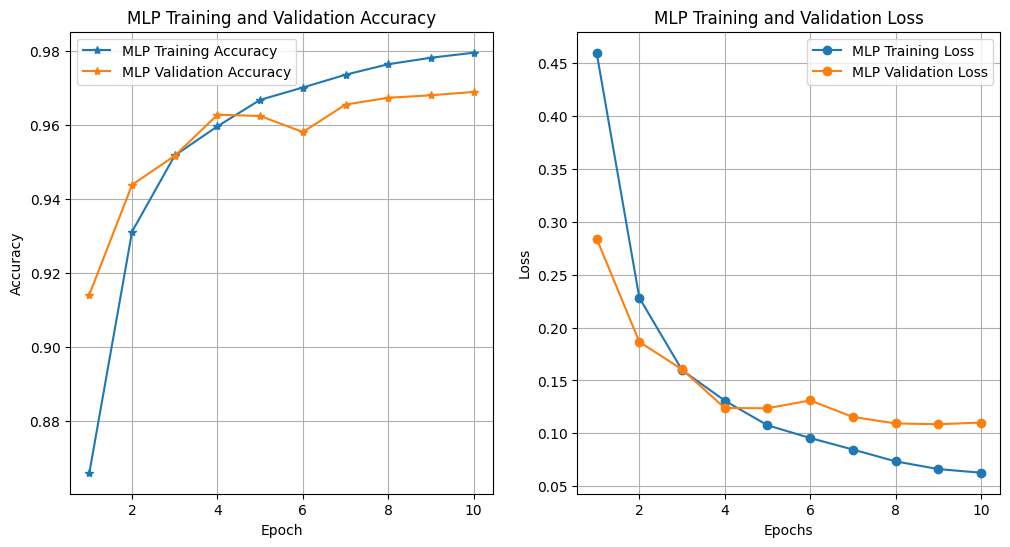

In [44]:
epochs = range(1, len(mlp_train_losses) + 1)

# Create a new figure with specified size
plt.figure(figsize=(12, 6))

# Create the first subplot (1 row, 2 columns, 1st subplot)
plt.subplot(1, 2, 1)

# Plot MLP training accuracy over epochs
plt.plot(epochs, mlp_train_accs, '-*', label='MLP Training Accuracy')
# Plot MLP validation accuracy over epochs
plt.plot(epochs, mlp_val_accs, '-*', label='MLP Validation Accuracy')

# Set the x-axis label to 'Epoch'
plt.xlabel('Epoch')
# Set the y-axis label to 'Accuracy'
plt.ylabel('Accuracy')
# Set the title of the first subplot
plt.title('MLP Training and Validation Accuracy')
# Add a legend to the first subplot
plt.legend()
# Enable grid lines on the first subplot
plt.grid(True)

# Create the second subplot (1 row, 2 columns, 2nd subplot)
plt.subplot(1, 2, 2)

# Plot MLP training loss over epochs
plt.plot(epochs, mlp_train_losses, '-o', label='MLP Training Loss')
# Plot MLP validation loss over epochs
plt.plot(epochs, mlp_val_losses, '-o', label='MLP Validation Loss')

# Set the title of the second subplot
plt.title('MLP Training and Validation Loss')
# Set the x-axis label to 'Epochs'
plt.xlabel('Epochs')
# Set the y-axis label to 'Loss'
plt.ylabel('Loss')
# Add a legend to the second subplot
plt.legend()
# Enable grid lines on the second subplot
plt.grid(True)

# Display the figure with the subplots
plt.show()


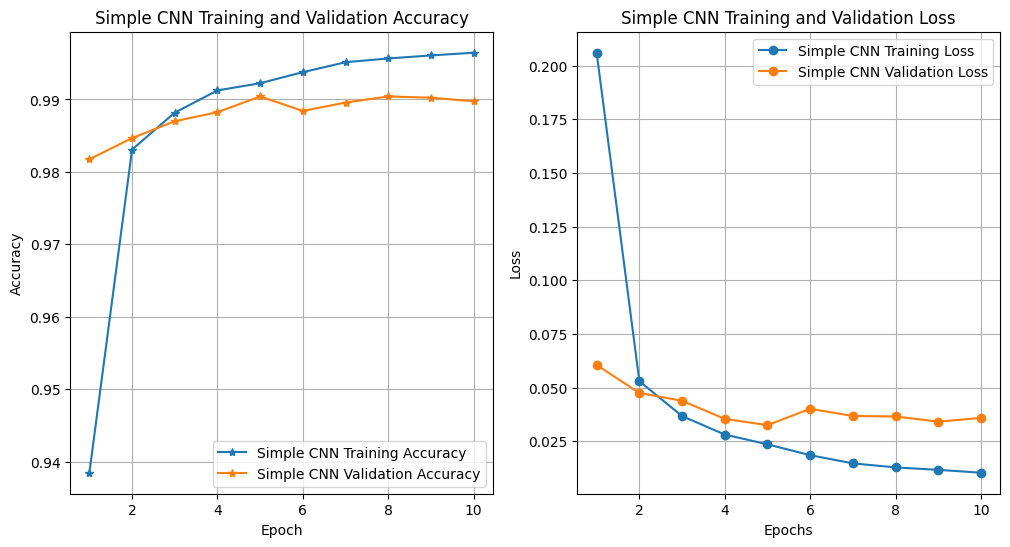

In [45]:
# Plotting Training and Validation Accuracy for Simple CNN Model
# Create a new figure with specified size
plt.figure(figsize=(12, 6))

# Create the first subplot (1 row, 2 columns, 1st subplot)
plt.subplot(1, 2, 1)

# Plot Simple CNN training accuracy over epochs
plt.plot(epochs, cnn_train_accs, '-*', label='Simple CNN Training Accuracy')
# Plot Simple CNN validation accuracy over epochs
plt.plot(epochs, cnn_val_accs, '-*', label='Simple CNN Validation Accuracy')

# Set the x-axis label to 'Epoch'
plt.xlabel('Epoch')
# Set the y-axis label to 'Accuracy'
plt.ylabel('Accuracy')
# Set the title of the first subplot
plt.title('Simple CNN Training and Validation Accuracy')
# Add a legend to the first subplot
plt.legend()
# Enable grid lines on the first subplot
plt.grid(True)

# Create the second subplot (1 row, 2 columns, 2nd subplot)
plt.subplot(1, 2, 2)

# Plot Simple CNN training loss over epochs
plt.plot(epochs, cnn_train_losses, '-o', label='Simple CNN Training Loss')
# Plot Simple CNN validation loss over epochs
plt.plot(epochs, cnn_val_losses, '-o', label='Simple CNN Validation Loss')

# Set the title of the second subplot
plt.title('Simple CNN Training and Validation Loss')
# Set the x-axis label to 'Epochs'
plt.xlabel('Epochs')
# Set the y-axis label to 'Loss'
plt.ylabel('Loss')
# Add a legend to the second subplot
plt.legend()
# Enable grid lines on the second subplot
plt.grid(True)

# Display the figure with the subplots
plt.show()


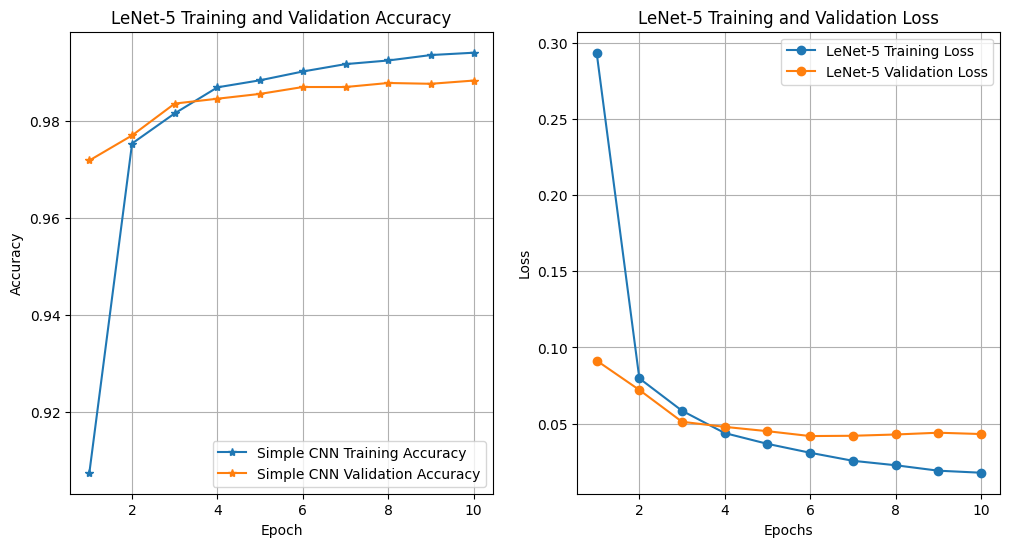

In [46]:
# Plotting Training and Validation Accuracy for LeNet5 Model
# Create a new figure with specified size
plt.figure(figsize=(12, 6))

# Create the first subplot (1 row, 2 columns, 1st subplot)
plt.subplot(1, 2, 1)

# Plot LeNet-5 training accuracy over epochs
plt.plot(epochs, lenet_train_accs, '-*', label='LeNet-5 Training Accuracy')
# Plot LeNet-5 validation accuracy over epochs
plt.plot(epochs, lenet_val_accs, '-*', label='LeNet-5 Validation Accuracy')

# Set the x-axis label to 'Epoch'
plt.xlabel('Epoch')
# Set the y-axis label to 'Accuracy'
plt.ylabel('Accuracy')
# Set the title of the first subplot
plt.title('LeNet-5 Training and Validation Accuracy')
# Add a legend to the first subplot
plt.legend()
# Enable grid lines on the first subplot
plt.grid(True)

# Create the second subplot (1 row, 2 columns, 2nd subplot)
plt.subplot(1, 2, 2)

# Plot LeNet-5 training loss over epochs
plt.plot(epochs, lenet_train_losses, '-o', label='LeNet-5 Training Loss')
# Plot LeNet-5 validation loss over epochs
plt.plot(epochs, lenet_val_losses, '-o', label='LeNet-5 Validation Loss')

# Set the title of the second subplot
plt.title('LeNet-5 Training and Validation Loss')
# Set the x-axis label to 'Epochs'
plt.xlabel('Epochs')
# Set the y-axis label to 'Loss'
plt.ylabel('Loss')
# Add a legend to the second subplot
plt.legend()
# Enable grid lines on the second subplot
plt.grid(True)

# Display the figure with the subplots
plt.show()


# Loading the Saved Model

In [17]:
# Load the trained model weights (assume models are saved as 'mlp_model.pth', 'cnn_model.pth', 'lenet_model.pth')
mlp_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition_model/mlp_model.pth'))
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition_model/simple_cnn_model.pth'))
lenet_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition_model/lenet5_model.pth'))

<All keys matched successfully>

In [19]:
# Evaluate models on test set
print("MLP Model Loading ")
mlp_test_acc, mlp_labels, mlp_preds = test_model(mlp_model, test_loader)
print("Simple CNN Model Loading ")
cnn_test_acc, cnn_labels, cnn_preds = test_model(cnn_model, test_loader)
print("LeNet 5 Model Loading ")
lenet_test_acc, lenet_labels, lenet_preds = test_model(lenet_model, test_loader)

MLP Model Loading 
Test Accuracy: 0.9687
Simple CNN Model Loading 
Test Accuracy: 0.9909
LeNet 5 Model Loading 
Test Accuracy: 0.9877


# Checking the Model Predictions

In [20]:
# Display sample images and their predictions
def show_images(images, labels, preds, ncols=8):
    # Calculate the number of rows needed to display all images
    nrows = np.ceil(len(images) / ncols).astype(int)
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7))
    
    # Iterate through all subplots in the grid
    for i, ax in enumerate(axes.flat):
        # Check if there are more images to display
        if i < len(images):
            # Display the current image, reshaped to 28x28 and in grayscale
            ax.imshow(images[i].reshape(28, 28), cmap='gray')
            # Set the title of the subplot with true and predicted labels
            ax.set_title(f'True: {labels[i]} Pred: {preds[i]}')
        # Turn off axis labels for better visualization
        ax.axis('off')

    # Adjust the layout of subplots to prevent overlap
    plt.tight_layout()
    # Display the figure with all subplots
    plt.show()


In [21]:
# Display sample images and predictions for each model
# Retrieve the next batch of samples from the test_loader
test_samples = next(iter(test_loader))

# Separate the test_images and test_labels from the test_samples
test_images, test_labels = test_samples

# Convert test_images from PyTorch tensor to a NumPy array
test_images = test_images.numpy()



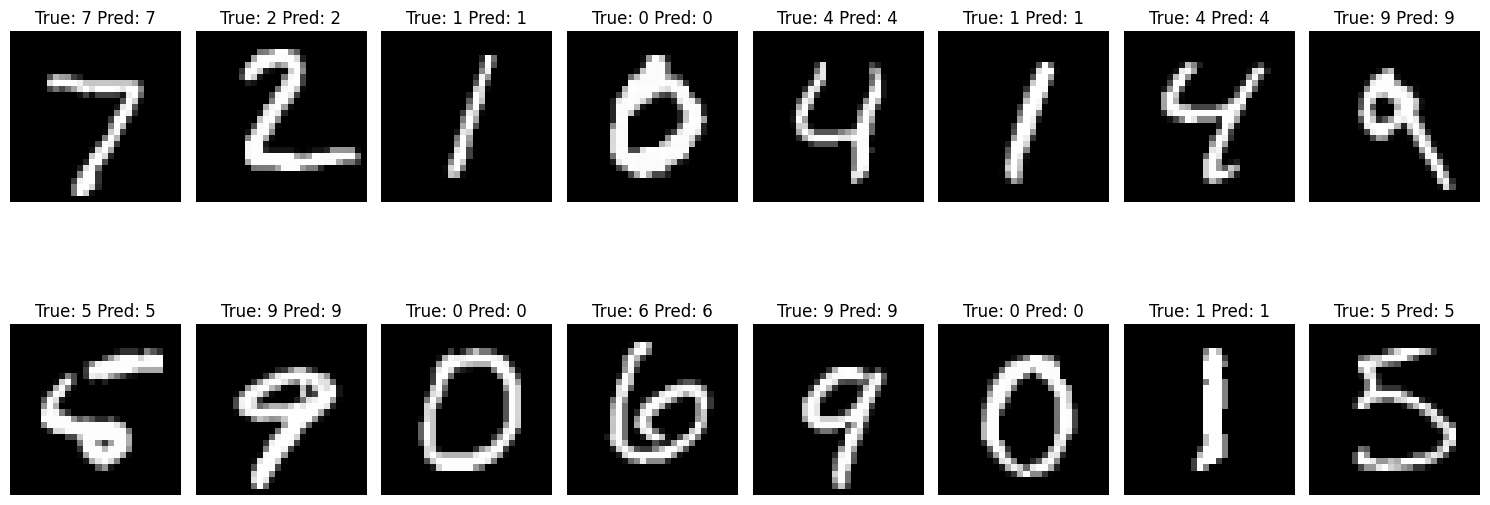

In [22]:
# MLP predictions
show_images(test_images[:16], mlp_labels[:16], mlp_preds[:16])

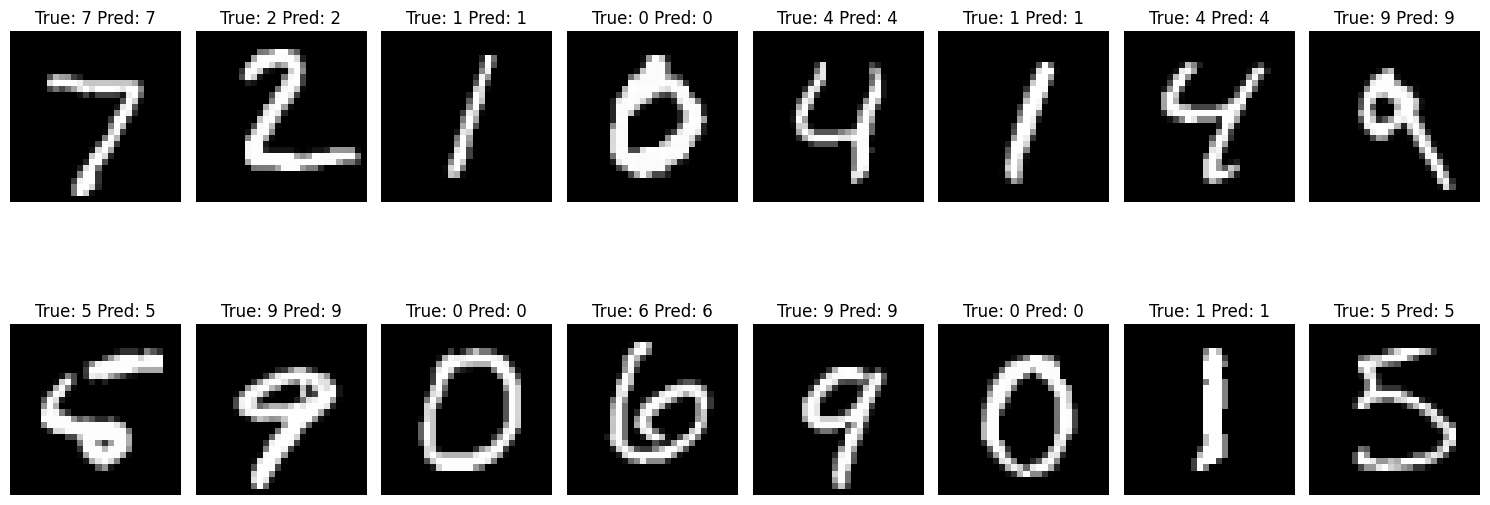

In [23]:
# Simple CNN predictions
show_images(test_images[:16], cnn_labels[:16], cnn_preds[:16])

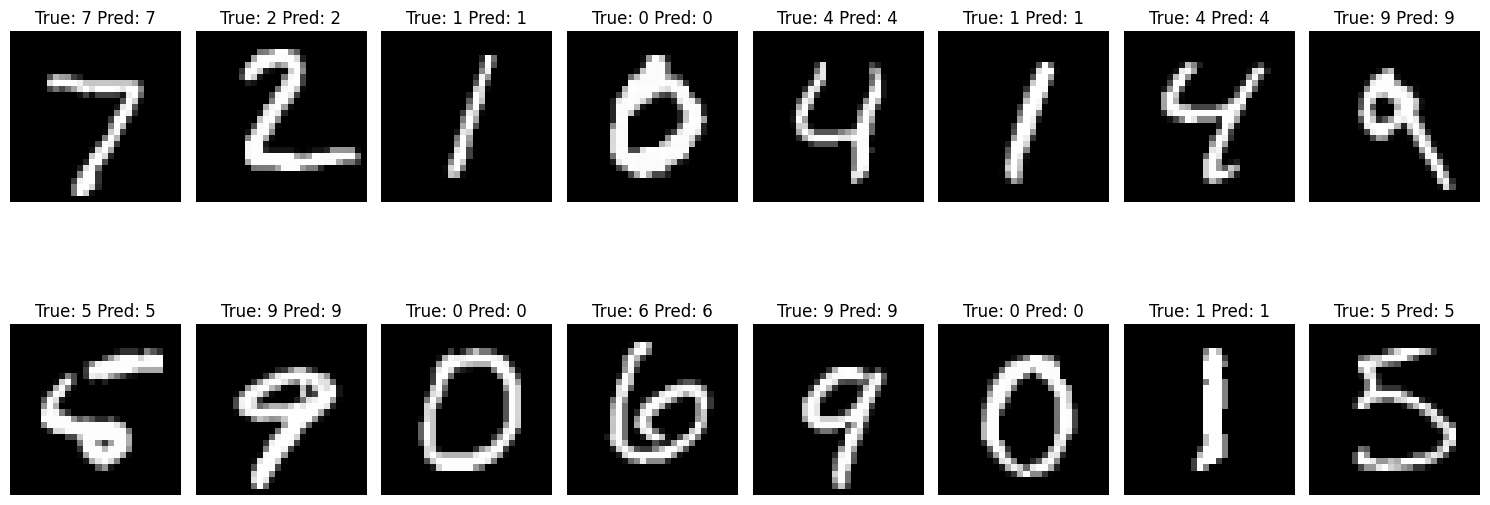

In [24]:
# LeNet-5 predictions
show_images(test_images[:16], lenet_labels[:16], lenet_preds[:16])